In [3]:
# --- SEL 1: INSTALASI LIBRARY ---
import pandas as pd
import numpy as np
import csv
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Download resource NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Konfigurasi Visualisasi agar terlihat 'Academic'
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to C:\Users\Dea Zasqia P.
[nltk_data]     Malau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Dea Zasqia P.
[nltk_data]     Malau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# --- SEL 2: PEMROSESAN DATA MENTAH (RAW DATA HANDLING) ---

def load_and_repair_csv(filename):
    """
    Fungsi robust untuk membaca CSV yang formatnya rusak (banyak koma, kolom bergeser).
    Menggunakan 'URL' sebagai anchor (jangkar) untuk memetakan kolom.
    """
    cleaned_rows = []
    
    with open(filename, 'r', encoding='utf-8', errors='replace') as f:
        reader = csv.reader(f)
        try:
            header = next(reader) # Skip header asli
        except StopIteration:
            return pd.DataFrame()

        for row in reader:
            # Hapus kolom kosong di akhir (trailing commas)
            while row and row[-1] == '':
                row.pop()
            
            if not row: continue
            
            # --- LOGIKA PERBAIKAN KOLOM ---
            # Mencari indeks kolom URL (biasanya berisi 'http')
            url_index = -1
            for i, col in enumerate(row):
                if 'http' in col:
                    url_index = i
                    break
            
            if url_index != -1:
                # Mapping data berdasarkan posisi URL
                doc_id = row[0]
                
                # Title: Gabungan dari index 1 sampai sebelum Source
                # (Mengatasi judul yang mengandung koma)
                title = ",".join(row[1 : url_index - 1]).strip().strip('"')
                
                source = row[url_index - 1].strip()
                url = row[url_index].strip()
                
                # Date: Gabungan kolom setelah URL sampai sebelum Content
                publish_date = ",".join(row[url_index + 1 : -1]).strip().strip('"')
                
                # Content: Kolom terakhir
                content = row[-1].strip().strip('"')
                
                cleaned_rows.append([doc_id, title, source, url, publish_date, content])

    return pd.DataFrame(cleaned_rows, columns=['Doc_ID', 'Title', 'Source', 'URL', 'Date', 'Content'])

# 1. Load Data
print("🔄 Sedang memuat dan memperbaiki data...")
df = load_and_repair_csv('korpus_pendidikan_gabungan.csv')
print(f"✅ Data berhasil dimuat! Total Dokumen: {len(df)}")

# 2. Simpan Versi 'Kotor' (Raw) untuk Lampiran
df.to_csv('Lampiran_Data_Mentah.csv', index=False)
print("📂 File 'Lampiran_Data_Mentah.csv' telah disimpan.")

# 3. Tampilkan sampel
df.head(3)

🔄 Sedang memuat dan memperbaiki data...
✅ Data berhasil dimuat! Total Dokumen: 315
📂 File 'Lampiran_Data_Mentah.csv' telah disimpan.


,Doc_ID,Title,Source,URL,Date,Content
0,DETIK_001,"Perkuat Pendidikan Vokasi, Menko PM Usul Pembentukan Badan Vokasi Nasional",Detik,https://news.detik.com/berita/d-8210710/perkuat-pendidikan-vokasi-menko-pm-usul-pembentukan-badan-vokasi-nasional,"Jumat, 14 Nov 2025 15:19 WIB","Menteri Koordinator Pemberdayaan Masyarakat A. Muhaimin Iskandar mendorong pembentukan Badan Vokasi Nasional (BVN) guna memperkuat pendidikan vokasi yang terintegrasi dengan kebutuhan industri. Ia menilai lembaga itu penting untuk mengatasi masalah vokasi, dari ketidakselarasan kurikulum hingga rendahnya penyerapan lulusan SMK. ""Sistem vokasi nasional harus terus dikembangkan. Saya mengusulkan dibuat, didirikan Badan Vokasi Nasional, BVN,"" kata Muhaimin dalam keterangan tertulis, Jumat (14/11/2025). Menurut Muhaimin, temuan di lapangan menunjukkan lembaga pendidikan vokasi dengan sistem maju mampu memenuhi kebutuhan pasar kerja dalam dan luar negeri, salah satunya ia lihat saat mengunjungi Sekolah Analis Kimia Bogor (SMAKBO) yang dibina Kementerian Perindustrian. Sistem vokasi terintegrasi melalui BVN diyakini dapat mengatasi berbagai masalah SMK dan lembaga vokasi, mulai dari kurikulum yang tidak selaras (mismatch) dengan industri, pelatihan yang tumpang tindih antar Kementerian/Lembaga, hingga penyaluran lulusan, sejalan dengan perhatian Presiden Prabowo Subianto. Salah satu tantangan utama adalah belum efektifnya sertifikasi keahlian dan bahasa asing berstandar internasional bagi lulusan SMK dan lembaga vokasi. Menurut Muhaimin, BVN akan menghadirkan sistem pengelolaan yang lebih efektif sehingga lulusan SMK dapat lebih cepat terserap di pasar kerja, baik dalam maupun luar negeri. ""Pasar kerja di dalam maupun di luar negeri sangat potensial tetapi pendidikan dan vokasi perlu dikonsolidasikan lebih cepat sehingga memberikan kesempatan kepada masyarakat generasi muda untuk cepat meng-update kapasitasnya,"" ujarnya. Pengelolaan vokasi di Indonesia saat ini masih belum terpadu dan belum mampu secara efektif menyerap lulusan SMK maupun lembaga pendidikan vokasi lainnya ke dunia kerja. Data Badan Pusat Statistik (BPS) mencatat sekitar 1,63 juta lulusan SMK masih menganggur dan tidak melanjutkan kuliah. Hambatan utama mereka untuk masuk ke pasar kerja internasional adalah minimnya keterampilan serta kemampuan bahasa yang menjadi syarat bekerja di luar negeri."
1,DETIK_002,"Ikuti Arahan Prabowo, Pratikno Rapat Lintas Kementerian Bahas Pendidikan Vokasi",Detik,https://news.detik.com/berita/d-8210385/ikuti-arahan-prabowo-pratikno-rapat-lintas-kementerian-bahas-pendidikan-vokasi,"Jumat, 14 Nov 2025 12:54 WIB","Menteri Koordinator Pembangunan Manusia dan Kebudayaan (Menko PMK) Pratikno menggelar rapat tertutup dengan lintas Kementerian. Rapat tersebut membahas pendidikan dan pelatihan vokasi. Rapat digelar di Lantai 14, Gedung Kemenko PMK, Jakarta Pusat, Jumat (14/11/2025). Rapat dipimpin langsung oleh Pratikno dan dihadiri jajaran Kementerian seperti Wamen P2MI Christina Aryani. Pratikno menjelaskan rapat lintas Kementerian ini digelar untuk menindaklanjuti arahan Presiden Prabowo Subianto pada rapat kabinet 4-5 November 2025 lalu. Ia menyebut salah satu arahan Prabowo yakni merevitalisasi pendidikan dan pelatihan vokasi. ""Jadi Pak Presiden memerintahkan salah satunya adalah perihal revitalisasi pendidikan vokasi dan pelatihan vokasi. Jadi perintahnya Pak Presiden revitalisasi pendidikan dan pelatihan vokasi ini bukan hanya untuk kebutuhan pasar kerja di dalam negeri, tetapi juga kebutuhan pasar pekerja di luar negeri,"" kata Pratikno usai rapat lintas Kementerian. Pratikno mengatakan saat ini banyak negara-negara yang mengalami krisis society. Di sisi lain, ia mengatakan Indonesia tengah mengalami bonus demografi. ""Nah ini penting untuk dikembangkan dalam rangka mengisi pasar kerja di luar negeri dan juga secara khusus meningkatkan kesejahteraan masyarakat kita. Oleh karena itu, atas perintah Bapak Presiden tersebut, kami pada hari ini menyelenggarakan ra

In [5]:
# --- SEL 3: PREPROCESSING & PERBANDINGAN STEP-BY-STEP ---

# Inisialisasi Stemmer & Stopwords
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))
# Tambahan stopword spesifik berita
custom_stop = {'baca', 'juga', 'halaman', 'kompas', 'detik', 'com', 'wib', 'jakarta', 'copyright', 'advertisement'}
stop_words.update(custom_stop)

def preprocess_detailed(text):
    """Mengembalikan teks bersih DAN dictionary langkah-langkahnya (untuk laporan)"""
    steps = {}
    steps['1. Original'] = text
    
    # Case Folding
    text = text.lower()
    steps['2. Case Folding'] = text
    
    # Cleaning
    text = re.sub(r'http\S+', '', text) # Hapus URL
    text = re.sub(r'[^a-z\s]', '', text) # Hapus angka & simbol
    steps['3. Cleaning'] = text
    
    # Tokenizing
    tokens = text.split()
    
    # Stopword Removal
    tokens = [w for w in tokens if w not in stop_words]
    steps['4. Stopword Removal'] = " ".join(tokens)
    
    # Stemming (Sastrawi)
    stemmed_tokens = [stemmer.stem(w) for w in tokens]
    final_text = " ".join(stemmed_tokens)
    steps['5. Stemming (Final)'] = final_text
    
    return final_text, steps

# --- A. PROSES DATA UTAMA (Cepat) ---
print("⚙️ Sedang melakukan preprocessing (estimasi 1-3 menit karena Stemming)...")
# Menggunakan apply dengan fungsi sederhana agar cepat
df['Clean_Content'] = df['Content'].apply(lambda x: preprocess_detailed(x)[0])

# Simpan Versi 'Bersih' (Preprocessed) untuk Lampiran
df[['Doc_ID', 'Title', 'Clean_Content']].to_csv('Lampiran_Data_Bersih.csv', index=False)
print("📂 File 'Lampiran_Data_Bersih.csv' telah disimpan.")

# --- B. BUAT TABEL BEFORE-AFTER (Untuk Laporan) ---
# Ambil 1 sampel dokumen untuk didemokan
sample_doc = df['Content'].iloc[0][:300] + "..." # Potong biar gak kepanjangan
_, demo_steps = preprocess_detailed(sample_doc)

df_steps = pd.DataFrame(list(demo_steps.items()), columns=['Tahapan', 'Hasil Teks'])

print("\n=== TABEL PERBANDINGAN PREPROCESSING (Salin ini ke Laporan) ===")
display(df_steps)

⚙️ Sedang melakukan preprocessing (estimasi 1-3 menit karena Stemming)...
📂 File 'Lampiran_Data_Bersih.csv' telah disimpan.

=== TABEL PERBANDINGAN PREPROCESSING (Salin ini ke Laporan) ===


,Tahapan,Hasil Teks
0,1. Original,"Menteri Koordinator Pemberdayaan Masyarakat A. Muhaimin Iskandar mendorong pembentukan Badan Vokasi Nasional (BVN) guna memperkuat pendidikan vokasi yang terintegrasi dengan kebutuhan industri. Ia menilai lembaga itu penting untuk mengatasi masalah vokasi, dari ketidakselarasan kurikulum hingga rend..."
1,2. Case Folding,"menteri koordinator pemberdayaan masyarakat a. muhaimin iskandar mendorong pembentukan badan vokasi nasional (bvn) guna memperkuat pendidikan vokasi yang terintegrasi dengan kebutuhan industri. ia menilai lembaga itu penting untuk mengatasi masalah vokasi, dari ketidakselarasan kurikulum hingga rend..."
2,3. Cleaning,menteri koordinator pemberdayaan masyarakat a muhaimin iskandar mendorong pembentukan badan vokasi nasional bvn guna memperkuat pendidikan vokasi yang terintegrasi dengan kebutuhan industri ia menilai lembaga itu penting untuk mengatasi masalah vokasi dari ketidakselarasan kurikulum hingga rend
3,4. Stopword Removal,menteri koordinator pemberdayaan masyarakat a muhaimin iskandar mendorong pembentukan badan vokasi nasional bvn memperkuat pendidikan vokasi terintegrasi kebutuhan industri menilai lembaga mengatasi vokasi ketidakselarasan kurikulum rend
4,5. Stemming (Final),menteri koordinator daya masyarakat a muhaimin iskandar dorong bentuk badan vokasi nasional bvn kuat didik vokasi integrasi butuh industri nilai lembaga atas vokasi ketidakselarasan kurikulum rend


📊 Menampilkan Visualisasi...


C:\Users\Dea Zasqia P. Malau\AppData\Local\Temp\ipykernel_23896\4130481962.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(y), y=list(x), palette='viridis')


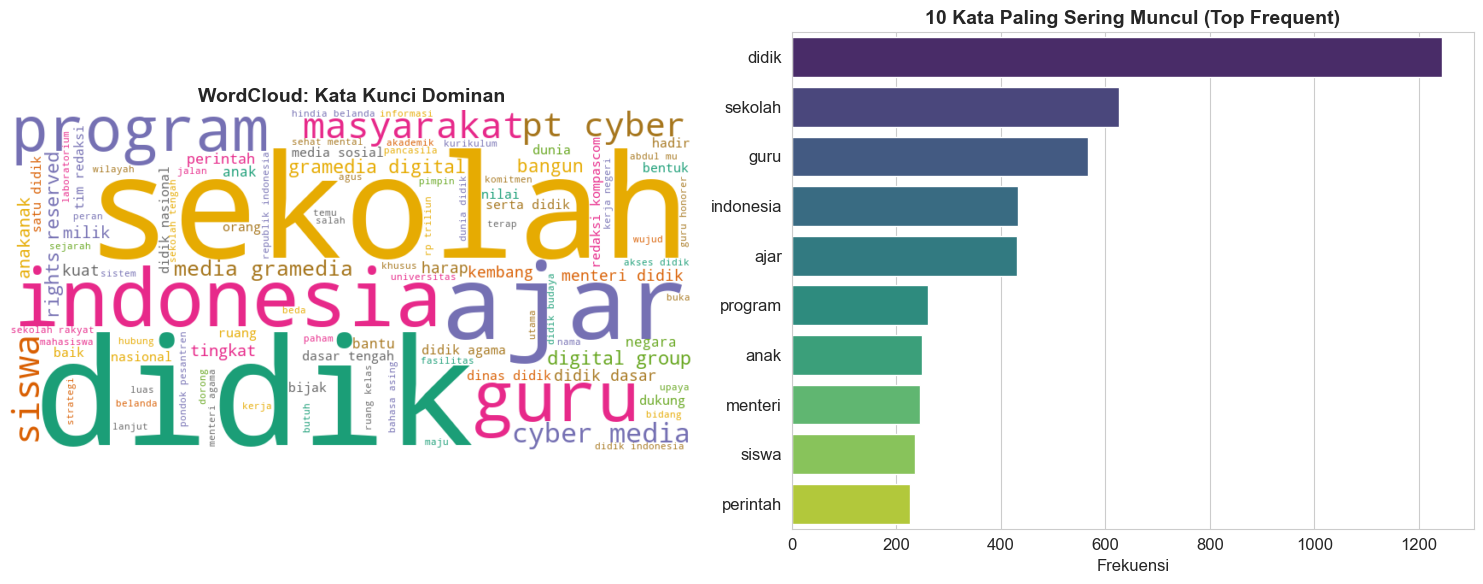

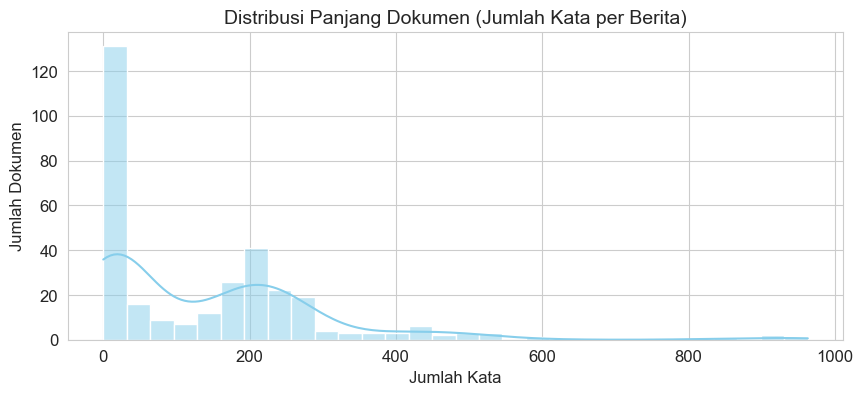

In [6]:
# --- SEL 4: VISUALISASI DATA KORPUS ---

def generate_visualizations(df):
    # Gabungkan semua teks bersih
    all_text = " ".join(df['Clean_Content'])
    
    # 1. WordCloud
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white', 
                          colormap='Dark2',
                          max_words=100).generate(all_text)
    
    plt.figure(figsize=(15, 6))
    
    # Plot WordCloud
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud: Kata Kunci Dominan', fontsize=14, fontweight='bold')
    
    # 2. Bar Chart (Top 10 Words)
    from collections import Counter
    words = all_text.split()
    counter = Counter(words)
    most_common = counter.most_common(10)
    x, y = zip(*most_common)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=list(y), y=list(x), palette='viridis')
    plt.title('10 Kata Paling Sering Muncul (Top Frequent)', fontsize=14, fontweight='bold')
    plt.xlabel('Frekuensi')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Distribusi Panjang Dokumen
    doc_lens = df['Clean_Content'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 4))
    sns.histplot(doc_lens, kde=True, color='skyblue', bins=30)
    plt.title('Distribusi Panjang Dokumen (Jumlah Kata per Berita)', fontsize=14)
    plt.xlabel('Jumlah Kata')
    plt.ylabel('Jumlah Dokumen')
    plt.show()

print("📊 Menampilkan Visualisasi...")
generate_visualizations(df)

In [7]:
# --- SEL 5: BUILD MODEL & TESTING MANUAL (VERSI LENGKAP DENGAN IMPORT) ---

# 1. Import Library yang dibutuhkan (Jaga-jaga jika belum di-run di atas)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
import time
import numpy as np

print("⏳ Sedang membangun indeks TF-IDF dan BM25... (Mohon tunggu)")

# Cek apakah Dataframe sudah ada
if 'df' not in locals():
    print("❌ ERROR: Dataframe 'df' belum ada. Tolong jalankan Sel 2 dan Sel 3 dulu!")
else:
    # A. MEMBANGUN MODEL TF-IDF
    vectorizer = TfidfVectorizer()
    # Pastikan kolom 'Clean_Content' sudah dibuat di Sel 3
    if 'Clean_Content' not in df.columns:
         print("❌ ERROR: Kolom 'Clean_Content' tidak ditemukan. Jalankan Sel 3 (Preprocessing) dulu!")
    else:
        tfidf_matrix = vectorizer.fit_transform(df['Clean_Content'])

        # B. MEMBANGUN MODEL BM25
        tokenized_corpus = [doc.split() for doc in df['Clean_Content']]
        bm25 = BM25Okapi(tokenized_corpus)

        # C. FUNGSI PENCARIAN TERPADU
        def search_system(query, top_k=10):
            # Preprocessing Query (Pastikan fungsi preprocess_detailed ada di Sel 3)
            # Jika error 'preprocess_detailed not defined', jalankan Sel 3 lagi
            try:
                clean_query, _ = preprocess_detailed(query)
            except NameError:
                # Fallback simple prepro jika fungsi tidak ditemukan
                clean_query = query.lower() 
            
            # --- METODE 1: TF-IDF ---
            start_time = time.time()
            query_vec = vectorizer.transform([clean_query])
            tfidf_scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
            tfidf_indices = tfidf_scores.argsort()[-top_k:][::-1]
            tfidf_time = time.time() - start_time
            
            # --- METODE 2: BM25 ---
            start_time = time.time()
            query_tokens = clean_query.split()
            bm25_scores = bm25.get_scores(query_tokens)
            bm25_indices = np.argsort(bm25_scores)[-top_k:][::-1]
            bm25_time = time.time() - start_time
            
            return {
                'tfidf': (tfidf_indices, tfidf_scores, tfidf_time),
                'bm25': (bm25_indices, bm25_scores, bm25_time),
                'clean_query': clean_query
            }

        print("✅ Model BERHASIL dibangun!")

        # --- TESTING MANUAL ---
        print("\n=== 🧪 TEST PENCARIAN OTOMATIS ===")
        test_query = "pendidikan vokasi"
        print(f"Mencoba mencari: '{test_query}'...\n")

        res = search_system(test_query)
        top_idx = res['bm25'][0][0]
        top_score = res['bm25'][1][top_idx]
        print(f"Hasil Teratas BM25: {df.iloc[top_idx]['Title']}")
        print(f"Skor: {top_score:.4f}")

⏳ Sedang membangun indeks TF-IDF dan BM25... (Mohon tunggu)
✅ Model BERHASIL dibangun!

=== 🧪 TEST PENCARIAN OTOMATIS ===
Mencoba mencari: 'pendidikan vokasi'...

Hasil Teratas BM25: Perkuat Pendidikan Vokasi, Menko PM Usul Pembentukan Badan Vokasi Nasional
Skor: 8.8086


In [ ]:
# --- SEL 6: GUI INTERAKTIF (FINAL PRODUCT) ---

# Widget Input
input_box = widgets.Text(
    placeholder='Masukkan kata kunci (misal: kurikulum merdeka, beasiswa)',
    description='<b>Pencarian:</b>',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

btn_search = widgets.Button(
    description='Telusuri',
    button_style='primary',
    icon='search',
    layout=widgets.Layout(width='15%')
)

output_display = widgets.Output()

def format_result_html(indices, scores, method_name, exec_time):
    """Membuat tabel hasil pencarian yang cantik dengan HTML"""
    html = f"""
    <div style="border: 1px solid #ddd; border-radius: 5px; padding: 10px; margin: 5px;">
        <h3 style="color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 5px;">
            Metode {method_name}
        </h3>
        <p style="font-size: 12px; color: gray;">Waktu Eksekusi: <b>{exec_time:.5f} detik</b></p>
        <table style="width:100%; border-collapse: collapse; font-family: Arial, sans-serif;">
            <tr style="background-color: #f8f9fa; color: #333;">
                <th style="padding: 8px; border-bottom: 1px solid #ddd; text-align: left;">Rank</th>
                <th style="padding: 8px; border-bottom: 1px solid #ddd; text-align: left;">Score</th>
                <th style="padding: 8px; border-bottom: 1px solid #ddd; text-align: left;">Judul & Cuplikan</th>
            </tr>
    """
    
    found_any = False
    for rank, idx in enumerate(indices):
        score = scores[idx]
        if score > 0.0001: # Threshold relevansi
            found_any = True
            title = df.iloc[idx]['Title']
            # Highlight title if too long
            display_title = (title[:60] + '...') if len(title) > 60 else title
            date = df.iloc[idx]['Date']
            snippet = df.iloc[idx]['Content'][:150] + "..."
            
            html += f"""
            <tr style="border-bottom: 1px solid #eee;">
                <td style="padding: 8px; font-weight: bold;">{rank+1}</td>
                <td style="padding: 8px; color: #e74c3c;">{score:.4f}</td>
                <td style="padding: 8px;">
                    <div style="font-weight: bold; color: #1a0dab; font-size: 14px;">{display_title}</div>
                    <div style="font-size: 11px; color: #006621;">{date}</div>
                    <div style="font-size: 12px; color: #545454;">{snippet}</div>
                </td>
            </tr>
            """
    
    if not found_any:
        html += "<tr><td colspan='3' style='padding:10px; text-align:center;'>Tidak ada dokumen yang relevan ditemukan.</td></tr>"
        
    html += "</table></div>"
    return html

def on_search_click(b):
    with output_display:
        clear_output()
        query = input_box.value.strip()
        
        if not query:
            print("⚠️ Mohon masukkan kata kunci pencarian!")
            return
            
        # Panggil fungsi pencarian sistem
        results = search_system(query)
        
        # Ambil data hasil
        res_tfidf = results['tfidf']
        res_bm25 = results['bm25']
        
        display(HTML(f"<h3>Hasil Pencarian untuk: <i>'{query}'</i> (Clean: '{results['clean_query']}')</h3>"))
        
        # Tampilkan Side-by-Side menggunakan Grid Layout Widget
        html_tfidf = format_result_html(res_tfidf[0], res_tfidf[1], "TF-IDF", res_tfidf[2])
        html_bm25 = format_result_html(res_bm25[0], res_bm25[1], "BM25 (Best Match)", res_bm25[2])
        
        grid = widgets.GridspecLayout(1, 2)
        grid[0, 0] = widgets.HTML(html_tfidf)
        grid[0, 1] = widgets.HTML(html_bm25)
        
        display(grid)

btn_search.on_click(on_search_click)

# Layout Container
header = widgets.HTML("<h1 style='text-align:center; color:#2c3e50;'>🎓 Mesin Pencari Berita Pendidikan (Kelompok 10)</h1>")
footer = widgets.HTML("<div style='text-align:center; margin-top:20px; font-size:12px; color:grey;'>Projek Akhir Penelusuran Informasi - TF-IDF vs BM25</div>")

# TAMPILKAN GUI
display(widgets.VBox([
    header,
    widgets.HBox([input_box, btn_search], layout=widgets.Layout(justify_content='center', margin='20px 0')),
    output_display,
    footer
]))